In [1]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(stringr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#using the read_csv function to load data from web
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
tennis_data <- tennis |>
  select(Age, 'Prize Money', 'Current Rank') |>
map_df(~sum(is.na(.)))
names(tennis_data) <- c("Age", "Prize Money", "Current_rank")
tennis_data

Age,Prize Money,Current_rank
<int>,<int>,<int>
1,81,5


In [4]:
tennis_data <- tennis |>
select(Age, 'Prize Money', 'Current Rank') 
names(tennis_data) <- c("Age", "Prize", "Current_rank")
tennis_data <- tennis_data |>
  select(Age, Prize, Current_rank)
head(tennis_data)

Age,Prize,Current_rank
<chr>,<chr>,<chr>
26 (25-04-1993),NA,378 (97)
18 (22-12-2001),"$59,040",326 (119)
32 (03-11-1987),"US$3,261,567",178 (280)
21 (29-05-1998),"$374,093",236 (199)
27 (21-10-1992),"US$6,091,971",183 (273)
22 (11-02-1997),"$1,517,157",31 (1398)


In [37]:
tennis_data <- tennis_data |>
select(Age, Prize, Current_rank) %>%
mutate(across(Age: Current_rank, function(col) {str_extract(col, "^[^ ]+")}))|>
mutate(Prize = as.numeric(gsub("[^0-9.]+", "", Prize)))|>
                mutate(Age = as.numeric(Age))|>
                mutate(Current_rank = as.numeric(Current_rank))|>
  filter(!is.na(Prize) & !is.na(Age) & !is.na(Current_rank)) |>
  filter(Prize <= 100000000) |>
  mutate(rank_top_150 = ifelse(Current_rank <= 150, "top 150", "not top 150")) |>
  mutate(rank_top_150 = as.factor(rank_top_150)) |>
  select(Age, Prize, rank_top_150)

head(tennis_data)

Age,Prize,rank_top_150
<dbl>,<dbl>,<fct>
18,59040,not top 150
32,3261567,not top 150
21,374093,not top 150
27,6091971,not top 150
22,1517157,top 150
28,278709,not top 150


In [38]:
set.seed(999)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = rank_top_150)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)
glimpse(tennis_train)
glimpse(tennis_test)

Rows: 293
Columns: 3
$ Age          <dbl> 18, 32, 21, 27, 28, 21, 30, 30, 26, 24, 21, 28, 20, 22, 2…
$ Prize        <dbl> 59040, 3261567, 374093, 6091971, 278709, 59123, 184328, 1…
$ rank_top_150 <fct> not top 150, not top 150, not top 150, not top 150, not t…
Rows: 99
Columns: 3
$ Age          <dbl> 22, 25, 20, 28, 23, 30, 22, 30, 22, 28, 26, 34, 27, 22, 3…
$ Prize        <dbl> 1517157, 122734, 74927, 303458, 54004, 898701, 87942, 631…
$ rank_top_150 <fct> top 150, not top 150, top 150, top 150, not top 150, top …


In [39]:
set.seed(999)
tennis_summary_avg <- tennis_train %>%
  group_by(rank_top_150) %>%
  summarize(
    avg_age = mean(Age),
    avg_current_rank = mean(Prize)
  )

tennis_summary_avg

tennis_summary_sd <- tennis_train %>%
  group_by(rank_top_150) %>%
  summarize(
    sd_age = sd(Age),
    sd_current_rank = sd(Prize)
  )

tennis_summary_sd

rank_top_150,avg_age,avg_current_rank
<fct>,<dbl>,<dbl>
not top 150,25.75897,886894.7
top 150,26.91837,4240960.7


rank_top_150,sd_age,sd_current_rank
<fct>,<dbl>,<dbl>
not top 150,4.475403,1925523
top 150,4.202781,5466542


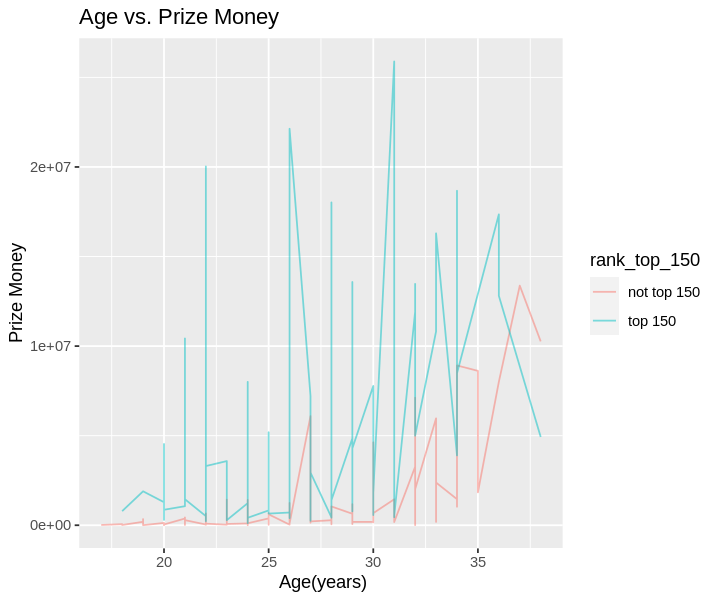

In [40]:
options(repr.plot.height = 5, repr.plot.width = 6)
handedness_age_vs_rank <- tennis_train|>
    filter(rank_top_150 != "NA") |>
    ggplot(aes(x = Age, y = Prize, 
            color = rank_top_150)) +
  geom_line(alpha = 0.5) +
  labs(x = " Age(years)", y = "Prize Money") +
  ggtitle("Age vs. Prize Money") 

handedness_age_vs_rank

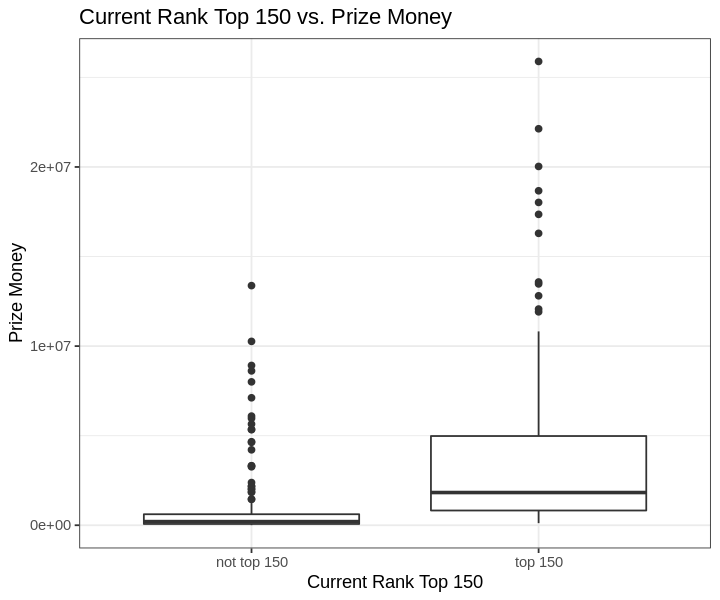

In [41]:
set.seed(999)
current_rank_plot <- ggplot(tennis_train, aes(x = rank_top_150, y = Prize)) +
  geom_boxplot() +
  xlab("Current Rank Top 150") +
  ylab("Prize Money") +
  ggtitle("Current Rank Top 150 vs. Prize Money") +
  theme_bw() 

current_rank_plot

In [42]:
set.seed(999)
tennis_proportions <- tennis_train |>
                      group_by(rank_top_150) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(tennis_train))

tennis_proportions

rank_top_150,n,percent
<fct>,<int>,<dbl>
not top 150,195,66.5529
top 150,98,33.4471


In [43]:
set.seed(999) 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

tennis_recipe <- recipe(rank_top_150 ~., data = tennis_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = rank_top_150)

In [44]:
set.seed(999) 

knn_results <- workflow() |>
                 add_recipe(tennis_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = tennis_vfold, grid = 10) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')
accuracies
 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7484072,10,0.02508895,Preprocessor1_Model01
3,accuracy,binary,0.7922167,10,0.01342258,Preprocessor1_Model02
4,accuracy,binary,0.7922167,10,0.01342258,Preprocessor1_Model03
6,accuracy,binary,0.7958867,10,0.02192485,Preprocessor1_Model04
7,accuracy,binary,0.8026847,10,0.02005309,Preprocessor1_Model05
8,accuracy,binary,0.8026847,10,0.02005309,Preprocessor1_Model06
10,accuracy,binary,0.7921018,10,0.01764384,Preprocessor1_Model07
12,accuracy,binary,0.8093514,10,0.01915169,Preprocessor1_Model08
13,accuracy,binary,0.8093514,10,0.01895997,Preprocessor1_Model09


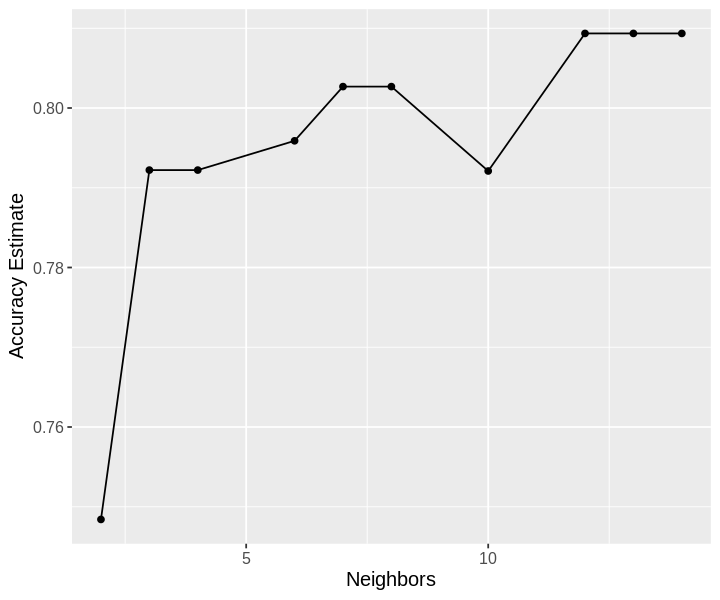

In [45]:
set.seed(999) 
options(repr.plot.height = 5, repr.plot.width = 6)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 12))

accuracy_vs_k

In [46]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
             add_recipe(tennis_recipe) |>
             add_model(knn_spec) |>
            fit(data = tennis_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1911263
Best kernel: rectangular
Best k: 13

In [47]:
set.seed(999) 

# your code here
tennis_predictions <- predict(knn_fit, tennis_test) |>
bind_cols(tennis_test)
head(tennis_predictions)

tennis_metrics <- tennis_predictions |>
         metrics(truth = rank_top_150, estimate = .pred_class) |>
  filter(.metric == "accuracy")
tennis_metrics

tennis_mat <- tennis_predictions |>
         conf_mat(truth = rank_top_150, estimate = .pred_class)
tennis_mat


.pred_class,Age,Prize,rank_top_150
<fct>,<dbl>,<dbl>,<fct>
top 150,22,1517157,top 150
not top 150,25,122734,not top 150
not top 150,20,74927,top 150
not top 150,28,303458,top 150
not top 150,23,54004,not top 150
not top 150,30,898701,top 150


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8383838


             Truth
Prediction    not top 150 top 150
  not top 150          64      14
  top 150               2      19